In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
import os

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  

# os.environ['OPENBLAS_NUM_THREADS'] = '1'

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

#env:lpr

### test 

In [37]:
events = NanoEventsFactory.from_root(
    '/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/TTJets/TTJets/merged_2.root',
    # '/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/QCD/QCD_HT1000to1500/merged_2.root',
).events()

events = events[ak.num(events.FatJet) >= 1]
# events = ak.concatenate([NanoEventsFactory.from_root(
#     f'/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/QCD/QCD_HT1000to1500/{i}.root',
# ).events() for i in range(10)], axis=0)

In [5]:
events

<NanoEventsArray [<event 1:100084:259915555>, ... ] type='330706 * event'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

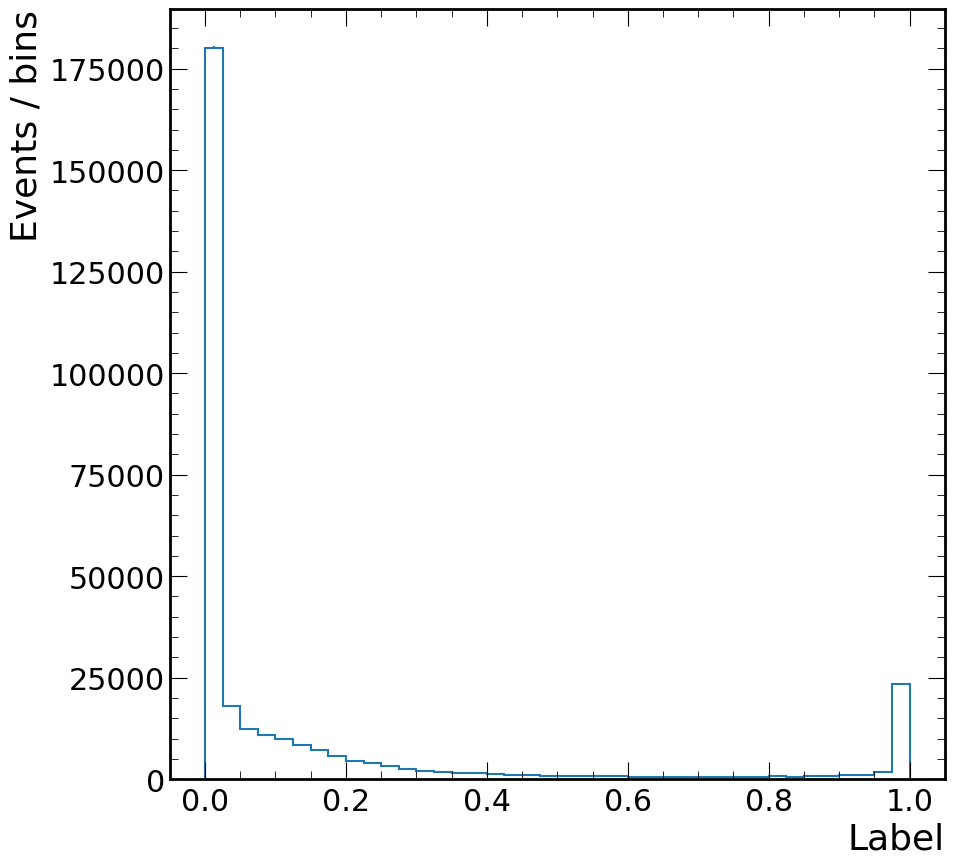

In [6]:
f, ax = plt.subplots(figsize=(10,10))

nbin, xmin, xmax = 40, 0, 1
hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
discr = f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
tagger_arr = ak.numexpr.evaluate(discr, events[ak.num(events.FatJet) >= 1].FatJet[:, 0])
hist.fill(tagger_arr[~np.isnan(tagger_arr)])
# hist.fill(arr_clean)
# 

content, yerr = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr)
ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);


### find tlb jet tagger distribution


In [35]:
deltaR = 0.8

d_PDGID = 1
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

In [38]:
# finding the two gen tops
tops = events.GenPart[
    (abs(events.GenPart.pdgId) == TOP_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]


In [8]:
num_jets = 1
fatjets = events.FatJet
leading_fatjets = ak.pad_none(fatjets, num_jets, axis=1)[:, :num_jets]

In [39]:
tops_children = tops.distinctChildren
tops_children = tops_children[tops_children.hasFlags(GEN_FLAGS)]
ws = ak.flatten(tops_children[np.abs(tops_children.pdgId) == W_PDGID], axis=2)

#only select semi-lep ttbar for simplicity
lep_top_sel = ((np.all(np.abs(ws.children.pdgId[:,0]) > 5,axis = 1) & (np.all(np.abs(ws.children.pdgId[:,1]) <= 5,axis = 1))) | (np.all(np.abs(ws.children.pdgId[:,1]) > 5,axis = 1) & (np.all(np.abs(ws.children.pdgId[:,0]) <= 5,axis = 1))))
#find the leptonic W
lep_ws_sel = np.all(np.abs(ws[lep_top_sel].children.pdgId) > 5, axis=2)
lep_ws = ak.flatten(ws[lep_top_sel][lep_ws_sel])
#find lepton
lepton_sel = (np.abs(lep_ws.children.pdgId) == 11) | ((np.abs(lep_ws.children.pdgId) == 13)) | ((np.abs(lep_ws.children.pdgId) == 15))
lepton = lep_ws.children[lepton_sel]
#find leptonic top
lep_tops = tops[lep_top_sel][lep_ws_sel]
lep_top_children = ak.flatten(lep_tops.children, axis=1)
lep_bs = lep_top_children[np.abs(lep_top_children.pdgId) == 5]


In [41]:
events

<NanoEventsArray [<event 1:100084:259915555>, ... ] type='330706 * event'>

In [40]:
lep_top_sel

<Array [False, True, False, ... False, False] type='330706 * ?bool'>

In [52]:
lep_top_sel_v2 = ak.fill_none(lep_top_sel,False)

In [53]:
lep_top_sel_v2

<Array [False, True, False, ... False, False] type='330706 * bool'>

In [51]:
if ak.any(np.isnan(lep_top_sel)): print("x")

In [43]:
events = events[lep_top_sel]

In [44]:
events

<NanoEventsArray [<event 1:100084:259915583>, ... ] type='142121 * ?event'>

In [25]:
def pad_val(
arr: ak.Array,
target: int,
value: float,
axis: int = 0,
to_numpy: bool = True,
clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret


In [10]:
leading_fatjets_leptop = leading_fatjets[lep_top_sel]

lep_jet_match = ak.flatten(
    pad_val(lepton.delta_r(leading_fatjets_leptop[:, 0]) < deltaR, 1, False, axis=1, to_numpy=False)
)
lep_b_jet_match = ak.flatten(
    pad_val(lep_bs.delta_r(leading_fatjets_leptop[:, 0]) < deltaR, 1, False, axis=1, to_numpy=False)
)


### plot tagger distri

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

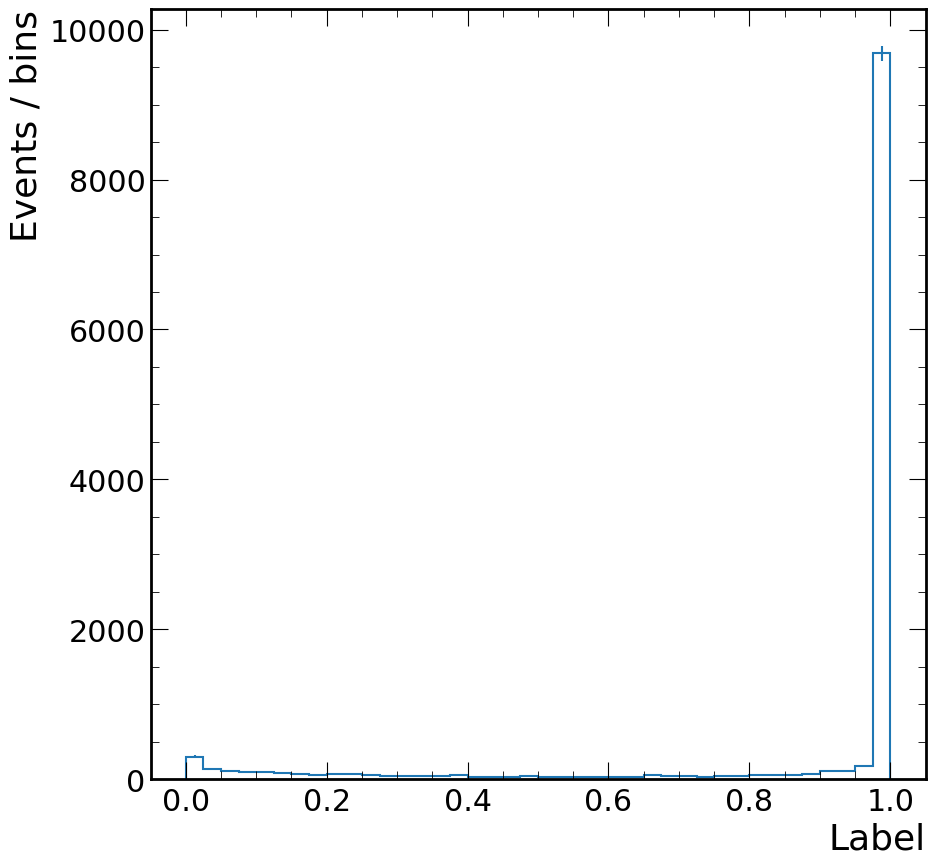

In [15]:
f, ax = plt.subplots(figsize=(10,10))

nbin, xmin, xmax = 40, 0, 1
hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
discr = f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
tagger_arr = ak.numexpr.evaluate(discr, leading_fatjets_leptop[lep_jet_match * lep_b_jet_match])[:,0]
hist.fill(tagger_arr[~np.isnan(tagger_arr)])
# hist.fill(arr_clean)
# 

content, yerr = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr)
ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);


### some check

In [16]:
# #not used for signal
# num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
# num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
# num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
# discr = f'({num}) / ({num} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
# arr = ak.numexpr.evaluate(discr, events[ak.num(events.FatJet) >= 1].FatJet[:, 0])
# np.quantile(arr[~np.isnan(arr)], q=0.99)

### processing

In [57]:
from coffea import processor, hist
from functools import partial

class TblNodeAnalyzeProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset = hist.Cat("dataset", "dataset")

        self._accumulator = processor.dict_accumulator({
            # defination of cutflow (nested dictionary of int) copied from the example
            'cutflow': processor.defaultdict_accumulator(
                partial(processor.defaultdict_accumulator, int)
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        out = self.accumulator.identity()
        dataset = events.metadata['dataset']
        out['cutflow'][dataset]['all'] += len(events)

        fname = f"coffea_output/{dataset}/{events.metadata['filename'].split('/')[-1].replace('.root','')}_{int(events.metadata['entrystop'])}.root"
        
        #at least one AK8 jets
        events = events[ak.num(events.FatJet) >= 1]
        
        # ======
        #gen-matching selection
        tops = events.GenPart[
        (abs(events.GenPart.pdgId) == TOP_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
        ]
        
        tops_children = tops.distinctChildren
        tops_children = tops_children[tops_children.hasFlags(GEN_FLAGS)]
        ws = ak.flatten(tops_children[np.abs(tops_children.pdgId) == W_PDGID], axis=2)
        
        #only select semi-lep ttbar for simplicity
        lep_top_sel = ((np.all(np.abs(ws.children.pdgId[:,0]) > 5,axis = 1) & (np.all(np.abs(ws.children.pdgId[:,1]) <= 5,axis = 1))) | (np.all(np.abs(ws.children.pdgId[:,1]) > 5,axis = 1) & (np.all(np.abs(ws.children.pdgId[:,0]) <= 5,axis = 1))))
        lep_top_sel = ak.fill_none(lep_top_sel,False)
        events = events[lep_top_sel] #semi-lep ttbar events
        
        # print(events)
        
        #find the leptonic W
        lep_ws_sel = np.all(np.abs(ws[lep_top_sel].children.pdgId) > 5, axis=2)
        lep_ws = ak.flatten(ws[lep_top_sel][lep_ws_sel])
        
        #find lepton
        lepton_sel = (np.abs(lep_ws.children.pdgId) == 11) | ((np.abs(lep_ws.children.pdgId) == 13)) | ((np.abs(lep_ws.children.pdgId) == 15))
        lepton = lep_ws.children[lepton_sel]
        
        #find leptonic top
        lep_tops = tops[lep_top_sel][lep_ws_sel]
        lep_top_children = ak.flatten(lep_tops.children, axis=1)
        lep_bs = lep_top_children[np.abs(lep_top_children.pdgId) == 5]

        #get leading Fatjet
        num_jets = 1
        fatjets = events.FatJet
        deltaR = 0.8
        leading_fatjets = ak.pad_none(fatjets, num_jets, axis=1)[:, :num_jets]
        
        lep_jet_match = ak.flatten(
            pad_val(lepton.delta_r(leading_fatjets[:, 0]) < deltaR, target = 1, value = False, axis=1, to_numpy=False)
        )
        lep_b_jet_match = ak.flatten(
            pad_val(lep_bs.delta_r(leading_fatjets[:, 0]) < deltaR, target = 1, value = False, axis=1, to_numpy=False)
        )
        
        #select the events whose leading jet is actually tbl jet
        events = events[ak.fill_none(lep_jet_match * lep_b_jet_match,False)]
        
        # =====
        
        # lepton selection
        lep_sel = (ak.num(events.Electron) + ak.num(events.Muon) == 1) & (ak.num(events.Jet) >= 2) & (ak.num(events.FatJet) >= 1)
        events = events[lep_sel]

        # the lepton object
        lep = ak.concatenate([events.Electron, events.Muon], axis=1)[:, 0]
        lep_isel = ak.num(events.Electron) > 0

        # jet and MET selection
        jet_sel = (events.Jet.pt[:, 0] > 50) & (events.Jet.pt[:, 1] > ak.where(lep_isel, 40, 50))
        jet_btagsel = ak.num(events.Jet[events.Jet.btagDeepFlavB > 0.3040]) >= 1 # MP in 2017 deepjet, https://btv-wiki.docs.cern.ch/ScaleFactors/UL2017/#ak4-b-tagging

        met_sel = events.MET.pt > ak.where(lep_isel, 60, 70)

        # fatjet selection
        fatjet = events.FatJet[:, 0]
        fatjet_sel = (fatjet.pt > 400) & (fatjet.msoftdrop > 105) & (fatjet.msoftdrop < 210)

        # fatjet top-tagging discr. We use ParT (MD) to construct the t->bqq discr and manually cut at 1% mistag WP
        num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
        num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
        discr = f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
        fatjet_toptagsel = ak.numexpr.evaluate(discr, fatjet) > 0.27 # 1% mistag rate on QCD

        # selection based on all objects
        # sel = jet_sel & jet_btagsel & met_sel & fatjet_sel & fatjet_toptagsel
        sel = jet_sel & jet_btagsel & met_sel # let's remove the fatjet sel for now
        events = events[sel]

        # ==== Now we finished all selections ====

        # define objects
        fj1 = events.FatJet[:, 0]
        fj2 = events.mask[ak.num(events.FatJet) >= 2].FatJet[:, 1] # use mask since a second fj may not exist

        jets = events.Jet
        lep = ak.concatenate([events.Electron, events.Muon], axis=1)[:, 0]
        lep_isel = ak.num(events.Electron) > 0

        # t->bqq discr
        num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
        fj1_ParTV1_discr_bqqvsQCD = ak.numexpr.evaluate(f'({num}) / ({num} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj1)
        
        # t->bl discr
        num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
        num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
        fj1_ParTV1_discr_blvsQCD = ak.numexpr.evaluate(f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj1)
        fj2_ParTV1_discr_blvsQCD = ak.numexpr.evaluate(f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj2)
        fj2_ParTV1_discr_bellvsQCD = ak.numexpr.evaluate(f'({num_bell}) / ({num_bell} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj2)

        # the 2D reconstruction workflow

        pair = ak.cartesian([lep, jets[jets.pt > 15]]) # all lep-jet pair with jet pt > 15
        dr_pair = pair['1'].delta_r(pair['0'])
        mindr_ind = ak.singletons(ak.argmin(dr_pair, axis=1))

        jet_closest = pair['1'][mindr_ind][:, 0]
        mindr = dr_pair[mindr_ind][:, 0]

        ptrel = lep.pt * np.abs(np.sin(lep.phi - jet_closest.phi)) # lep pt *perpendicular* to jet axis

        # construct output variables
        print("start store output")
        output = {}
        output['fj1_pt'] = fj1.pt
        output['fj1_eta'] = fj1.eta
        output['fj1_phi'] = fj1.phi
        output['fj1_sdmass'] = fj1.msoftdrop
        output['fj2_pt'] = ak.fill_none(fj2.pt, 0)
        output['fj2_eta'] = ak.fill_none(fj2.eta, 0)
        output['fj2_phi'] = ak.fill_none(fj2.phi, 0)
        output['fj2_sdmass'] = ak.fill_none(fj2.msoftdrop, 0)

        output['fj1_ParTV1_discr_bqqvsQCD'] = ak.fill_none(fj1_ParTV1_discr_bqqvsQCD, 0)
        output['fj1_ParTV1_discr_blvsQCD'] = ak.fill_none(fj1_ParTV1_discr_blvsQCD, 0)
        output['fj2_ParTV1_discr_blvsQCD'] = ak.fill_none(fj2_ParTV1_discr_blvsQCD, 0)
        output['fj2_ParTV1_discr_bellvsQCD'] = ak.fill_none(fj2_ParTV1_discr_bellvsQCD, 0)

        output['dr_fj12'] = ak.fill_none(fj1.delta_r(fj2), -1)

        output['lep_pt'] = lep.pt
        output['lep_eta'] = lep.eta
        output['lep_phi'] = lep.phi
        output['lep_isel'] = lep_isel
        output['lep_mindr_jet'] = mindr
        output['lep_ptrel_jet'] = ptrel

        output['deta_jet12'] = jets[:, 0].eta - jets[:, 1].eta

        # store root
        print(fname)
        os.makedirs(os.path.dirname(fname), exist_ok=True)
        with uproot.recreate(fname) as fout:
            output_root = {}
            for bname in output.keys():
                if not output[bname].fields:
                    output_root[bname] = ak.packed(ak.without_parameters(output[bname]))
                else:
                    b_nest = {}
                    for n in output[bname].fields:
                        b_nest[n] = ak.packed(ak.without_parameters(output[bname][n]))
                    output_root[bname] = ak.zip(b_nest)
            fout["tree"] = output_root

        out['cutflow'][dataset]['passed'] += len(events)
        return out
    
    def postprocess(self, accumulator):
        return accumulator

In [60]:
import glob
fileset = {
    'ttbar': glob.glob('/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/TTJets/TTJets/*1*.root'),
    # 'qcd': glob.glob('/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/QCD/QCD_HT1000to1500/*.root'),
}

In [61]:
result = processor.run_uproot_job(
    fileset=fileset,
    treename="Events",
    processor_instance=TblNodeAnalyzeProcessor(),
    executor=processor.futures_executor,
    executor_args={"schema": NanoAODSchema, "workers": 60},
)

start store output
coffea_output/ttbar/merged_181_299151.root
start store output
coffea_output/ttbar/merged_181_99717.root
start store output
coffea_output/ttbar/merged_181_498585.root
start store output
coffea_output/ttbar/merged_181_398868.root
start store output
coffea_output/ttbar/merged_181_199434.root
start store output
coffea_output/ttbar/merged_181_897453.root
start store output
coffea_output/ttbar/merged_181_598302.root
start store output
coffea_output/ttbar/merged_181_698019.root
start store output
coffea_output/ttbar/merged_181_997170.root
start store output
coffea_output/ttbar/merged_181_797736.root
start store output
coffea_output/ttbar/merged_124_299667.root
start store output
coffea_output/ttbar/merged_105_1067523.root
start store output
start store outputcoffea_output/ttbar/merged_124_799112.root

coffea_output/ttbar/merged_105_97048.root
start store output
coffea_output/ttbar/merged_105_873432.root
start store output
coffea_output/ttbar/merged_124_599334.root
start sto

start store output
coffea_output/ttbar/merged_11_1052901.root
